#### reading data files and creating dataframe

In [3]:
import pandas as pd
import numpy as np

# reading data

fe = open("assets/embedding.txt")
f = open("assets/text.txt")

texts = []
embeddings = []
for line in fe:
    embeddings.append(np.array([float(x) for x in line.split(',')]))
for line in f:
    texts.append(line)
df = pd.DataFrame({"embedding" : embeddings, "text" : texts})

#### clustering

In [27]:
from sklearn.cluster import KMeans
X = df['embedding'].tolist()

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
df["label"] = labels

#### understanding separation

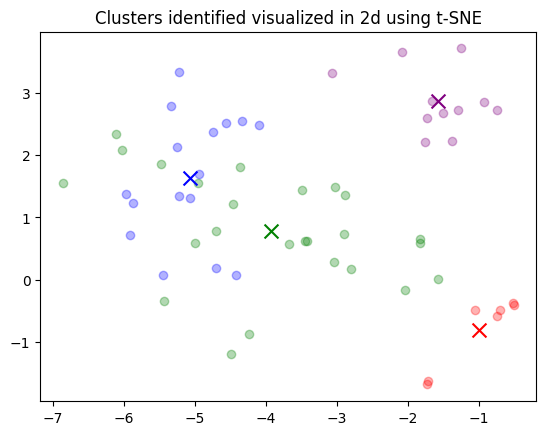

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
projection = tsne.fit_transform(np.array(X))

x = [x for x, y in projection]
y = [y for x, y in projection]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.label == category]
    ys = np.array(y)[df.label == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in 2d using t-SNE")
plt.show()

In [29]:
i = 0

for label in range(4):
    i += 1
    print('***'*10, "group ", ["purple", "green", "red", "blue"][label], " ",'***'*10)
    if label != -1:
        loc = df[df['label'] == label]
        for text in loc['text']:
            print(text.replace('\n',''))
    print('\n'*5)

****************************** group  purple   ******************************
Cheia de açúcar, a Coca-Cola é um perigo para a saúde!  #cocacola #açúcar #saúde
Refrigerantes como a Coca-Cola contribuem para o aumento da obesidade.  #cocacola #obesidade #preocupante
O consumo excessivo de Coca-Cola pode causar problemas de saúde como diabetes e doenças cardíacas. 🩺 #cocacola #saúde #riscos
A Coca-Cola é rica em cafeína, o que pode causar ansiedade e insônia.  #cocacola #cafeína #ansiedade
A produção da Coca-Cola utiliza muita água, um recurso precioso que precisa ser preservado.  #cocacola #água #sustentabilidade
A Coca-Cola é vendida como um símbolo de felicidade, mas na verdade pode ser prejudicial à saúde.  #cocacola #marketing #saúdemental
A empresa Coca-Cola é acusada de práticas antiéticas e de exploração de trabalhadores.  #cocacola #ética #exploração
O consumo de Coca-Cola pode contribuir para a formação de cáries e outros problemas dentários.  #cocacola #saúdebucal #dentes
Refri

In [74]:
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI, HarmCategory, HarmBlockThreshold
from langchain import PromptTemplate
from langchain.schema import StrOutputParser

load_dotenv()
llm = ChatGoogleGenerativeAI(
    model="gemini-pro", 
    temperature=0.7, 
    safety_settings={
        HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
        HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE
    }
)

# To query Gemini
llm_prompt_template = """I have a group of messages about coca-cola. What is the main context expressed in the messages?
MESSAGES:
"{text}"
MUST: answer in brazilian portuguese. Use at max 10 words.
CONTEXT:"""
llm_prompt = PromptTemplate.from_template(llm_prompt_template)

print(llm_prompt)

input_variables=['text'] template='I have a group of messages about coca-cola. What is the main context expressed in the messages?\nMESSAGES:\n"{text}"\nMUST: answer in brazilian portuguese. Use at max 10 words.\nCONTEXT:'


In [75]:
groups = df.groupby(['label'])['text'].apply(lambda x : '\n'.join(x))

In [82]:
stuff_chain = (
    # Extract data from the documents and add to the key `text`.
        {
            "text": lambda x : x
        }
        | llm_prompt         # Prompt for Gemini
        | llm                # Gemini function
        | StrOutputParser()  # output parser
    )
for group in groups:
    result = stuff_chain.invoke(group)
    print('example messages: \n')
    print('\n'.join(group.split('\n\n')[0:2]))
    print('\n', 'Result: \n', result)
    print('\n'*2)



example messages: 

Cheia de açúcar, a Coca-Cola é um perigo para a saúde!  #cocacola #açúcar #saúde
Refrigerantes como a Coca-Cola contribuem para o aumento da obesidade.  #cocacola #obesidade #preocupante

 Result: 
 Impactos negativos do consumo excessivo de refrigerantes, como a Coca-Cola.



example messages: 

Estudando pra prova com coca pra dar aquele gás!  #estudando #cocacola #concentração
Saindo do trabalho e nada melhor que uma coca pra refrescar!  #sextou #coca #refrescar

 Result: 
 O contexto é a experiência com o sabor da Coca-Cola.



example messages: 

Nada como um churrasco com os amigos e aquela coca gelada pra descer!  #churrasco #cocacola #gelada
Fim de semana pede relaxar e assistir um filminho com coquinha e pipoca.  #netflixandchill #coca #relax

 Result: 
 Momentos de descontração e confraternização



example messages: 

Coca-Cola, por favor, tragam de volta o sabor original! Essa nova fórmula está horrível. #coca #decepção
Desculpa, Coca-Cola, mas vocês mud

#### implementing semantic search

0.21466098281545254 A Coca-Cola é vendida como um símbolo de felicidade, mas na verdade pode ser prejudicial à saúde.  #cocacola #marketing #saúdemental

0.22241669413647036 Coca-Cola, o sabor que faz parte da sua vida!  #cocacola #sabor #vidamaisgostosa

0.24050741024292666 Happy hour com os amigos e a coca pra animar o encontro!  #happyhour #coca #amigos

0.24683397710259558 Noite de pizza com a galera e coca pra acompanhar!  #pizzaparty #cocacola #diversão



#### Classificação

In [44]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.prompts import ChatPromptTemplate
from langchain.prompts import HumanMessagePromptTemplate

llm = ChatGoogleGenerativeAI(
    model="gemini-pro", 
    temperature=0.3, 
    convert_system_message_to_human=True
) 

chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                """O grupo de comentários contém um contexto associado à marca ou bebida Coca-Cola. 
                Retorne o contexto associado, como um tópico, utilizando no máximo 3 palavras.
                A resposta nunca pode ser "coca-cola" ou "refrigerante"
                """
            )
        ),
        HumanMessagePromptTemplate.from_template("{text}"),
    ]
)

i = 0
for label in set(labels):
    i += 1
    if label != -1:
        print('***'*10, "group ", i, " ",'***'*10)
        loc = df[df['label'] == label]
        for text in loc['text']:
            print(text)
        chat_message =  chat_template.format_messages(text=str(loc['text'].values))
        response = llm.invoke(chat_message)
        print("answer: ", response.content)

****************************** group  1   ******************************
Happy hour com os amigos e a coca pra animar o encontro!  #happyhour #coca #amigos

Noite de pizza com a galera e coca pra acompanhar!  #pizzaparty #cocacola #diversão

Partiu praia com a galera e a galera de coca pra ninguém ficar sem! ️ #ferias #cocagelada #amigos

answer:  Encontro entre amigos
****************************** group  2   ******************************
Coca-Cola, o sabor que faz parte da sua vida!  #cocacola #sabor #vidamaisgostosa

Sensação de frescor que só a Coca-Cola proporciona! ❄️ #cocacola #frescor #sensação

Experimente o sabor original e autêntico da Coca-Cola!  #cocacola #sabororiginal #autêntico

Impossível resistir ao aroma inconfundível da Coca-Cola!  #cocacola #aroma #inconfundível

Aquele sabor único e refrescante da Coca-Cola que só quem prova sabe!  #cocacola #saborúnico #refrescante

answer:  Sabor Refrescante
****************************** group  3   ****************************